# Market generator Bühler - Fractional BM

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import datetime

# import base
import BuehlerVAE.src.market_generator as market_generator
from BuehlerVAE.src.utils import tosig

c:\Users\peter\OneDrive - TUM\Master TUM\Masterarbeit\MarketGenerators\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Signature order
order = 4

## Load monthly paths

In [3]:
ticker = "^GSPC"
method = "Fractional_BM"
params = {
    "n": 1000,
    "hurst": 0.75,
}
MG = market_generator.MarketGenerator(ticker, freq="Y", sig_order=order, own_params=params, method=method)

Computing log-signatures: 100%|██████████| 1000/1000 [00:00<00:00, 1187.61it/s]


## Plot paths

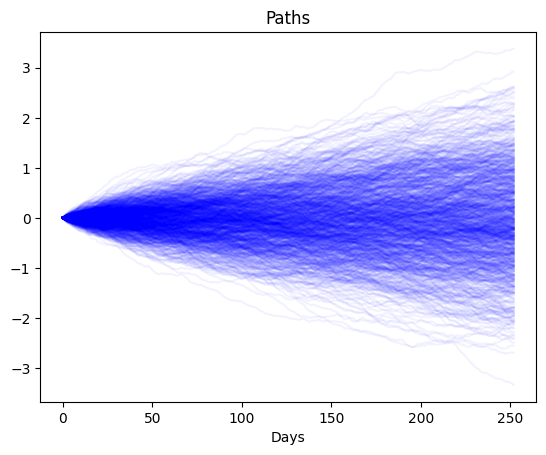

In [4]:
for path in MG.windows:
    returns = path[::2, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [5]:
MG.train(n_epochs=10000)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Training: 100%|██████████| 10000/10000 [00:22<00:00, 440.74it/s]


## Generate

In [6]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])
#generated = MG.generate(MG.conditions[100], n_samples=len(MG.logsigs))
#generated = MG.generate(MG.conditions[150][2] * 0.5, n_samples=len(MG.logsigs))

generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.orig_logsig)])

100%|██████████| 1000/1000 [00:15<00:00, 66.58it/s]


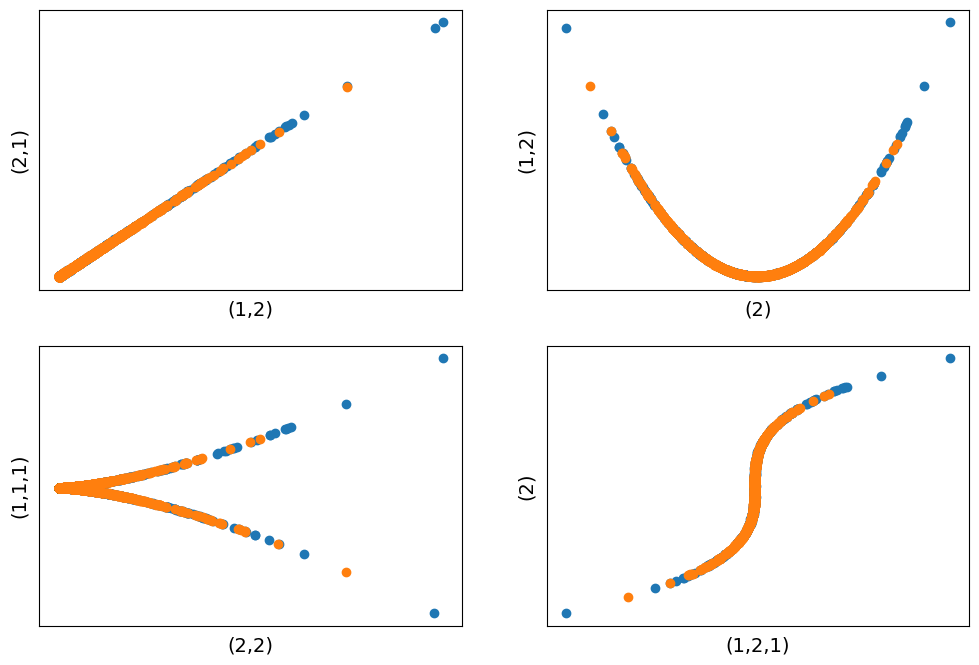

In [7]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

In [8]:
import BuehlerVAE.src.process_discriminator as process_discriminator

normalised_generated = np.array([MG.generate(cond, normalised=True) for cond in MG.conditions])
sigs1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(normalised_generated)])
MG._load_own_data(params, method)
sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.logsigs)])

res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.9999) # true for 0.99999 or more

print("Are the generated and real distributions DIFFERENT? {}".format(res))

Computing signatures of population 2: 100%|██████████| 999/999 [00:00<00:00, 2015.62it/s]

Are the generated and real distributions DIFFERENT? True


## Invert log-signature

In [9]:
import BuehlerVAE.src.logsig_inversion as logsig_inversion
from esig.tosig import stream2logsig
from BuehlerVAE.src.utils.leadlag import leadlag

logsig = MG.generate(MG.conditions[0])

In [10]:
pip = 0.0005
n_pips = 10*10
n_points = 252

n_iterations = 100
n_organisms = 150

recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

Loss: 0.10129525231848084: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


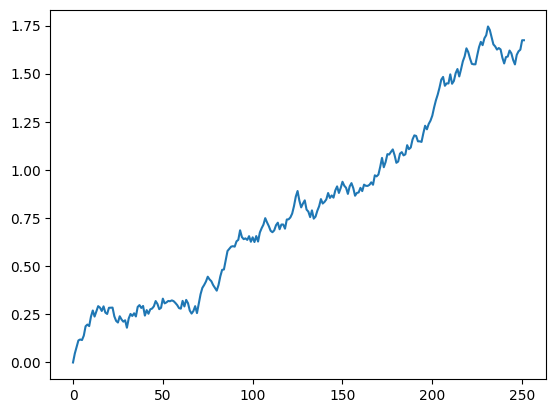

Target log-signature: [1.6168832778930664, 1.6199991703033447, -0.031494393944740295, -0.0023636866826564074, -0.0025583941023796797, -0.0007970824372023344, -0.001586955739185214, -0.0007949045393615961]
Recovered log-signature: [1.6735000000000004, 1.6735000000000004, -0.09742287499999991, -0.0023328333854168624, -0.0028105206145831265, -0.0007322491061874103, -0.0014419153240442795, -0.0007219799613126798]


In [11]:
plt.plot(recovered_path)
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), order).tolist()}")

In [12]:
recovered_paths = []
for condition in MG.conditions:
    logsig = MG.generate(condition)
    recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                                  pip, n_pips)
    
    recovered_paths.append(recovered_path)

Loss: 0.07423560061133609: 100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


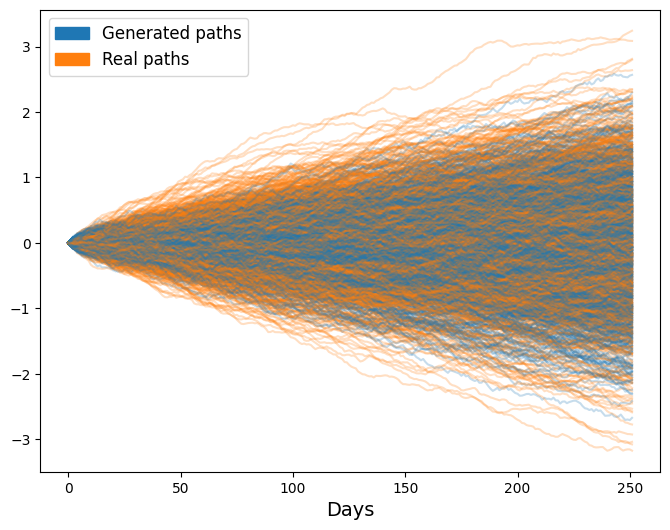

In [13]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))
for path1, path2 in zip(recovered_paths, MG.windows):
    returns = path2[::2, 1][:n_points] - path2[0, 1]
    plt.plot(returns, "C1", alpha=0.25)

    plt.plot(path1[:n_points], "C0", alpha=0.25)
    
blue_patch = mpatches.Patch(color='C0', label='Generated paths')
red_patch = mpatches.Patch(color='C1', label='Real paths')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)    
plt.xlabel("Days", fontsize=14) 
plt.show()

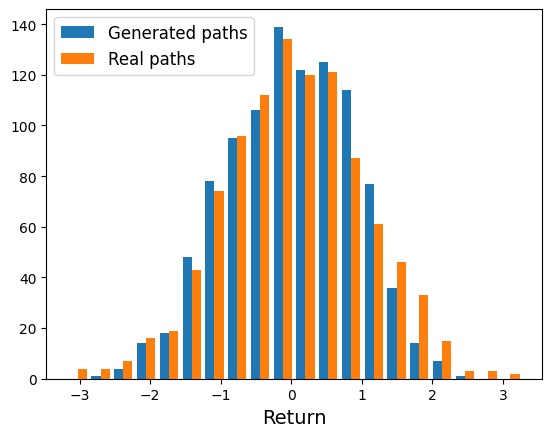

In [14]:
# This graph is somewhat week as the return over the whole month can be
# extracted from the signature directly from the first order terms (also for log-signature?)
returns1 = [path[-1] - path[0] for path in recovered_paths]
returns2 = [path[-1, 1] - path[0, 0] for path in MG.windows]

_ = plt.hist([returns1, returns2], bins=20, label=["Generated paths", "Real paths"])
plt.xlabel("Return", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [15]:
from hurst import compute_Hc
hursts_paths = []
cs_paths = []
for path in MG.windows:
    returns = path[::2, 1] - path[0, 1]
    hursts_paths.append(compute_Hc(returns, kind='random_walk', simplified=True)[1])
    cs_paths.append(compute_Hc(returns, kind='random_walk', simplified=True)[0])

In [16]:
hursts_generated = []
cs_generated = []
for path in recovered_paths:
    hursts_generated.append(compute_Hc(path, kind='random_walk', simplified=True)[1])
    cs_generated.append(compute_Hc(path, kind='random_walk', simplified=True)[0])

In [18]:
print(sum(cs_paths) / len(cs_paths))
print(sum(hursts_paths) / len(hursts_paths))
print(sum(cs_generated) / len(cs_generated))
print(sum(hursts_generated) / len(hursts_generated))

0.6982840917194123
1.3437821246768291
0.633084889831966
1.0200355001063353


In [1]:
# Export to csv
import pandas as pd
# Convert paths to pandas DataFrames
recovered_paths_df = pd.DataFrame(recovered_paths)
mg_windows_df = pd.DataFrame([path[::2, 1] - path[0, 1] for path in MG.windows])

# Save the DataFrames to CSV files
recovered_paths_df.to_csv('csv_export/recovered_paths_fbm_1000.csv', index=False)
mg_windows_df.to_csv('csv_export/mg_windows_fbm_1000.csv', index=False)

NameError: name 'recovered_paths' is not defined